In [41]:
import stompy.model.delft.dflow_model as dfm
import numpy as np
import logging
import pandas as pd
from matplotlib import dates

import xarray as xr
from stompy.grid import multi_ugrid
from stompy.spatial import join_features, wkb2shp
from stompy import utils, memoize, filters
from stompy.plot import plot_wkb
import os
import six
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib notebook

In [42]:
fig_dir="fig-scenarios-20220914"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [43]:
import run_database
six.moves.reload_module(run_database)

<module 'run_database' from '/home/rustyh/src/pescadero/model/model/run_database.py'>

In [44]:
import common
import six
six.moves.reload_module(common)

from common import *

In [45]:
# Get spring high tide waterline:
spring_period=[ min(spring_ebb[0],spring_flood[0]),
               max(spring_ebb[1],spring_flood[1])]

In [46]:
import run_database
six.moves.reload_module(run_database)

<module 'run_database' from '/home/rustyh/src/pescadero/model/model/run_database.py'>

In [47]:
def get_high_and_low(mds,spring_period):
    tidx_start,tidx_stop = np.searchsorted(mds.time.values,spring_period)

    eta_low=np.full(mds.grid.Ncells(),1000.0,np.float64)
    eta_high=np.full(mds.grid.Ncells(),-1000.0,np.float64)

    for tidx in utils.progress(range(tidx_start,tidx_stop)):
        eta=mds['mesh2d_s1'].isel(time=tidx).values
        eta_low=np.minimum(eta_low,eta)
        eta_high=np.maximum(eta_high,eta)
    return eta_high, eta_low

In [48]:
six.moves.reload_module(common)
dem=common.dem('asbuilt')

In [49]:
def cset_to_polygons(cset):
    segs=cset.allsegs[0][0]
    kinds=cset.allkinds[0][0]
    starts=np.nonzero( kinds==1 )[0]
    stops=np.r_[starts[1:],len(kinds)]

    segments=[]

    for start,stop in zip(starts,stops):
        segments.append( np.concatenate( [ segs[start:stop], segs[start:start+1]],axis=0 ) )

    polygons,extra=join_features.lines_to_polygons(segments,single_feature=False)
    return polygons

def wet_polygons_chunky(mds,eta,dz_min=0.1):
    depth=eta-mds.mesh2d_flowelem_bl.values
    node_depth=mds.grid.interp_cell_to_node(depth)
    plt.ioff()
    fig,ax=plt.subplots(num=999)
    cset=mds.grid.contourf_node_values(node_depth,[0.1,100],ax=ax)
    polygons=cset_to_polygons(cset)
    plt.close(999)
    plt.ion()
    return polygons


In [50]:
def wet_polygons(mds,eta,dz_min=0.01,dem=dem, area_min=100):
    z_bed=mds.mesh2d_flowelem_bl.values
    wet=eta-z_bed>dz_min
    fs_fld=field.rasterize_grid_cells(mds.grid,eta,cell_mask=wet,match=dem)
    fs_fld.fill_by_convolution(iterations=4) # SLOW
    
    wd=fs_fld.copy()
    wd.F-=dem.F
    
    border=-20
    wd.F[ np.isnan(wd.F)]=border
    wd.F[0,:]=border
    wd.F[-1,:]=border
    wd.F[:,0]=border
    wd.F[:,-1]=border
    contours=wd.trace_contour(0,10,union=False,method='gdal')
    segments=[np.array(l) for l in contours]
    merged=join_features.merge_lines(segments=segments)
    merged=join_features.tolerant_merge_lines(merged,0.5)
    polys,extras=join_features.lines_to_polygons(merged,single_feature=False,min_area=area_min)
    print("Extra features: ",len(extras))
    return polys

In [51]:
run=run_database.select(scen=0,layers=100,slr=0.0,period='2016tidal',flows='impaired',
                        load_model=True,single=True)

mds=run['model'].map_dataset(chain=False)

eta_high,eta_low=get_high_and_low(mds,spring_period)
polygons=wet_polygons(mds,eta_high)
wkb2shp.wkb2shp(os.path.join(fig_dir,'spring-hhw.shp'),polygons,overwrite=True)

polygons=wet_polygons(mds,eta_low)
wkb2shp.wkb2shp(os.path.join(fig_dir,'spring-llw.shp'),polygons,overwrite=True)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:join_features:Reading features
INFO:join_features:0 possible matched features
INFO:join_features:merge completed
INFO:join_features:0 open strings, 1511 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=450558.477838, 95 potential interiors


b'0...10...20...30...40...50...60...70...80...90...100 - done.\n'
b''


INFO:join_features:Examining largest poly left with area=32719.194055, 94 potential interiors
INFO:join_features:Examining largest poly left with area=18559.194669, 93 potential interiors
INFO:join_features:Examining largest poly left with area=4380.864250, 91 potential interiors
INFO:join_features:Examining largest poly left with area=4367.432489, 90 potential interiors
INFO:join_features:Examining largest poly left with area=3747.259531, 89 potential interiors
INFO:join_features:Examining largest poly left with area=2814.720586, 87 potential interiors
INFO:join_features:Examining largest poly left with area=2229.305058, 86 potential interiors
INFO:join_features:Examining largest poly left with area=1497.573600, 84 potential interiors
INFO:join_features:Examining largest poly left with area=1353.760816, 83 potential interiors
INFO:join_features:Examining largest poly left with area=1019.209951, 81 potential interiors
INFO:join_features:Examining largest poly left with area=985.251436,

Extra features:  0
Removing the old to make way for the new


INFO:join_features:Reading features
INFO:join_features:0 possible matched features
INFO:join_features:merge completed
INFO:join_features:0 open strings, 1666 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=191447.322755, 91 potential interiors


b'0...10...20...30...40...50...60...70...80...90...100 - done.\n'
b''


INFO:join_features:Examining largest poly left with area=37466.137669, 90 potential interiors
INFO:join_features:Examining largest poly left with area=31343.874613, 89 potential interiors
INFO:join_features:Examining largest poly left with area=16940.168574, 88 potential interiors
INFO:join_features:Examining largest poly left with area=7066.408524, 87 potential interiors
INFO:join_features:Examining largest poly left with area=4222.403404, 86 potential interiors
INFO:join_features:Examining largest poly left with area=3740.619256, 85 potential interiors
INFO:join_features:Examining largest poly left with area=3089.446480, 84 potential interiors
INFO:join_features:Examining largest poly left with area=2225.972912, 82 potential interiors
INFO:join_features:Examining largest poly left with area=1539.440252, 80 potential interiors
INFO:join_features:Examining largest poly left with area=1492.128826, 79 potential interiors
INFO:join_features:Examining largest poly left with area=1284.79931

Extra features:  0
Removing the old to make way for the new


In [52]:
run=run_database.select( scen=0,layers=100,slr=0.61,period='2016tidal',flows='impaired',
                        load_model=True,single=True)
mds=run['model'].map_dataset(chain=False)

eta_high,eta_low=get_high_and_low(mds,spring_period)
polygons=wet_polygons(mds,eta_high)
wkb2shp.wkb2shp(os.path.join(fig_dir,'spring-hhw-slr.shp'),polygons,overwrite=True)

polygons=wet_polygons(mds,eta_low)
wkb2shp.wkb2shp(os.path.join(fig_dir,'spring-llw-slr.shp'),polygons,overwrite=True)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:join_features:Reading features
INFO:join_features:0 possible matched features
INFO:join_features:merge completed
INFO:join_features:0 open strings, 685 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=1132025.609342, 49 potential interiors


b'0...10...20...30...40...50...60...70...80...90...100 - done.\n'
b''


INFO:join_features:Examining largest poly left with area=2439.834300, 47 potential interiors
INFO:join_features:Examining largest poly left with area=2321.965143, 46 potential interiors
INFO:join_features:Examining largest poly left with area=1147.364734, 43 potential interiors
INFO:join_features:Examining largest poly left with area=1095.007655, 42 potential interiors
INFO:join_features:Examining largest poly left with area=808.353999, 39 potential interiors
INFO:join_features:Examining largest poly left with area=794.934497, 38 potential interiors
INFO:join_features:Examining largest poly left with area=584.705584, 37 potential interiors
INFO:join_features:Examining largest poly left with area=507.766181, 35 potential interiors
INFO:join_features:Examining largest poly left with area=475.513352, 33 potential interiors
INFO:join_features:Examining largest poly left with area=390.345111, 32 potential interiors
INFO:join_features:Examining largest poly left with area=305.755041, 26 pote

Extra features:  0
Removing the old to make way for the new


INFO:join_features:Reading features
INFO:join_features:0 possible matched features
INFO:join_features:merge completed


b'0...10...20...30...40...50...60...70...80...90...100 - done.\n'
b''


INFO:join_features:0 open strings, 2629 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=461926.534525, 131 potential interiors
INFO:join_features:Examining largest poly left with area=5887.281188, 130 potential interiors
INFO:join_features:Examining largest poly left with area=4550.122366, 129 potential interiors
INFO:join_features:Examining largest poly left with area=3961.312109, 128 potential interiors
INFO:join_features:Examining largest poly left with area=3773.092097, 127 potential interiors
INFO:join_features:Examining largest poly left with area=3505.208392, 126 potential interiors
INFO:join_features:Examining largest poly left with area=2940.803147, 125 potential interiors
INFO:join_features:Examining largest poly left with area=2751.801148, 124 potential interiors
INFO:join_features:Examining largest poly left with area=2330.524242, 123 potential interiors
INFO:join_features:Exam

INFO:join_features:Examining largest poly left with area=148.798884, 25 potential interiors
INFO:join_features:Examining largest poly left with area=143.323709, 23 potential interiors
INFO:join_features:Examining largest poly left with area=136.662399, 22 potential interiors
INFO:join_features:Examining largest poly left with area=127.502146, 19 potential interiors
INFO:join_features:Examining largest poly left with area=121.229915, 16 potential interiors
INFO:join_features:Examining largest poly left with area=121.189872, 15 potential interiors
INFO:join_features:Examining largest poly left with area=120.655184, 14 potential interiors
INFO:join_features:Examining largest poly left with area=118.731545, 13 potential interiors
INFO:join_features:Examining largest poly left with area=118.398452, 12 potential interiors
INFO:join_features:Examining largest poly left with area=114.840118, 11 potential interiors
INFO:join_features:Examining largest poly left with area=113.178757, 10 potentia

Extra features:  0
Removing the old to make way for the new


In [53]:
run=run_database.select( scen=0,layers=100,slr=0.61,period='2016breach',flows='impaired',
                        load_model=True,single=True)
mds=run['model'].map_dataset(chain=False)

eta_high,eta_low=get_high_and_low(mds,
                                  [np.datetime64("2016-12-10"),
                                   np.datetime64("2016-12-12")])
polygons=wet_polygons(mds,eta_high)

wkb2shp.wkb2shp(os.path.join(fig_dir,'breach-2016-highwater-slr.shp'),polygons,overwrite=True)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:join_features:Reading features
INFO:join_features:0 possible matched features
INFO:join_features:merge completed
INFO:join_features:0 open strings, 306 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=1805522.675516, 25 potential interiors
INFO:join_features:Examining largest poly left with area=305.187640, 19 potential interiors
INFO:join_features:Examining largest poly left with area=183.479657, 12 potential interiors
INFO:join_features:Examining largest poly left with area=122.083835, 6 potential interiors
INFO:join_features:Examining largest poly left with area=106.050440, 1 pote

b'0...10...20...30...40...50...60...70...80...90...100 - done.\n'
b''
Extra features:  0


In [55]:
run=run_database.select( scen=0,layers=100,slr=0.00,period='2016breach',flows='impaired',
                        load_model=True,single=True)
mds=run['model'].map_dataset(chain=False)

eta_high,eta_low=get_high_and_low(mds,
                                  [np.datetime64("2016-12-10"),
                                   np.datetime64("2016-12-12")])
polygons=wet_polygons(mds,eta_high)
wkb2shp.wkb2shp(os.path.join(fig_dir,'breach-2016-highwater.shp'),polygons,overwrite=True)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:join_features:Reading features
INFO:join_features:0 possible matched features
INFO:join_features:merge completed
INFO:join_features:0 open strings, 290 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=1695702.518258, 28 potential interiors


b'0...10...20...30...40...50...60...70...80...90...100 - done.\n'
b''


INFO:join_features:Examining largest poly left with area=189.136377, 10 potential interiors
INFO:join_features:Examining largest poly left with area=182.690210, 7 potential interiors
INFO:join_features:Examining largest poly left with area=158.999817, 5 potential interiors
INFO:join_features:Examining largest poly left with area=140.988487, 2 potential interiors


Extra features:  0
Removing the old to make way for the new


In [56]:
# high flow
run=run_database.select( scen=0,layers=100,slr=0.00,period='2016long',flows='impaired',
                        load_model=True,single=True)
mds=run['model'].map_dataset(chain=False)

eta_high,eta_low=get_high_and_low(mds,
                                  [np.datetime64("2017-01-05"),
                                   np.datetime64("2017-02-15")])
polygons=wet_polygons(mds,eta_high)
wkb2shp.wkb2shp(os.path.join(fig_dir,'highflow-2016-highwater.shp'),polygons,overwrite=True)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:join_features:Reading features
INFO:join_features:0 possible matched features
INFO:join_features:merge completed
INFO:join_features:0 open strings, 779 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=1350928.087790, 73 potential interiors


b'0...10...20...30...40...50...60...70...80...90...100 - done.\n'
b''


INFO:join_features:Examining largest poly left with area=2344.940419, 67 potential interiors
INFO:join_features:Examining largest poly left with area=831.165350, 61 potential interiors
INFO:join_features:Examining largest poly left with area=672.510038, 58 potential interiors
INFO:join_features:Examining largest poly left with area=616.093053, 56 potential interiors
INFO:join_features:Examining largest poly left with area=412.092151, 53 potential interiors
INFO:join_features:Examining largest poly left with area=404.962116, 52 potential interiors
INFO:join_features:Examining largest poly left with area=328.866117, 47 potential interiors
INFO:join_features:Examining largest poly left with area=297.138657, 46 potential interiors
INFO:join_features:Examining largest poly left with area=284.936313, 45 potential interiors
INFO:join_features:Examining largest poly left with area=279.545658, 44 potential interiors
INFO:join_features:Examining largest poly left with area=233.699574, 39 potenti

Extra features:  0
Removing the old to make way for the new


In [57]:
# high flow
run=run_database.select( scen=0,layers=100,slr=0.61,period='2016long',flows='impaired',
                        load_model=True,single=True)
mds=run['model'].map_dataset(chain=False)

eta_high,eta_low=get_high_and_low(mds,
                                  [np.datetime64("2017-01-05"),
                                   np.datetime64("2017-02-15")])
polygons=wet_polygons(mds,eta_high)
wkb2shp.wkb2shp(os.path.join(fig_dir,'highflow-2016-highwater-slr.shp'),polygons,overwrite=True)


INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:join_features:Reading features
INFO:join_features:0 possible matched features
INFO:join_features:merge completed
INFO:join_features:0 open strings, 555 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=1620738.881855, 62 potential interiors


b'0...10...20...30...40...50...60...70...80...90...100 - done.\n'
b''


INFO:join_features:Examining largest poly left with area=3169.999119, 58 potential interiors
INFO:join_features:Examining largest poly left with area=2086.385700, 57 potential interiors
INFO:join_features:Examining largest poly left with area=1048.100496, 54 potential interiors
INFO:join_features:Examining largest poly left with area=1001.321207, 53 potential interiors
INFO:join_features:Examining largest poly left with area=442.456510, 43 potential interiors
INFO:join_features:Examining largest poly left with area=406.053363, 40 potential interiors
INFO:join_features:Examining largest poly left with area=404.830001, 39 potential interiors
INFO:join_features:Examining largest poly left with area=307.021802, 33 potential interiors
INFO:join_features:Examining largest poly left with area=300.526175, 32 potential interiors
INFO:join_features:Examining largest poly left with area=234.199748, 29 potential interiors
INFO:join_features:Examining largest poly left with area=233.710481, 28 pote

Extra features:  0
Removing the old to make way for the new


In [59]:
bg_img=field.GdalGrid("pesca-rev01sat layers.png")

Putting multiple channels as last index


<IPython.core.display.Javascript object>


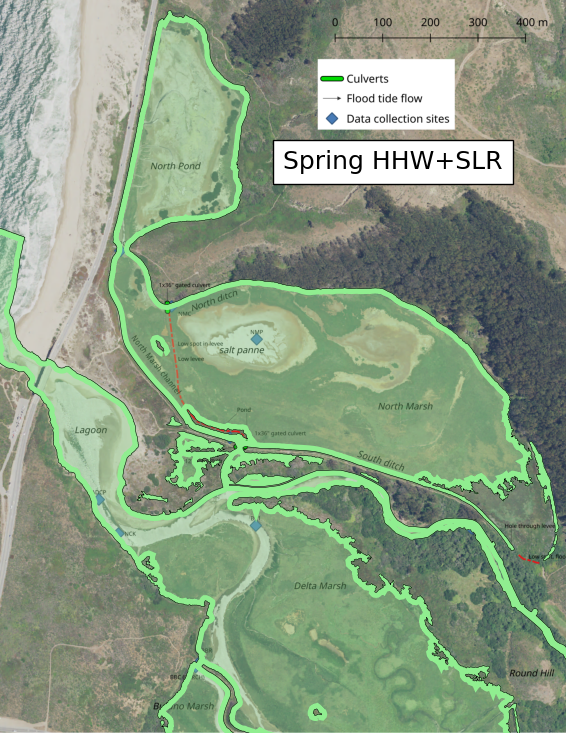

In [101]:
#colors=['blue','orange','tab:red','green','cyan']
#'tab:orange','tab:blue','tab:red','tab:brown','tab:purple',#'tab:green',
#        'tab:cyan']
#shps=[ #"highflow-2016-highwater-slr.shp",
#       "highflow-2016-highwater.shp",
#       'breach-2016-highwater.shp',
#       'breach-2016-highwater-slr.shp',
#       'spring-hhw.shp',
#       'spring-hhw-slr.shp'      
#     ]
#"highflow-2016-highwater-slr.shp",
     
settings=[
       (None,None,None),
       ("highflow-2016-highwater.shp",'yellow','High flow'),
       ('breach-2016-highwater.shp','orange','Breach'),
       ('breach-2016-highwater-slr.shp','tab:red','Breach+SLR'),
       ('spring-hhw.shp','cyan','Spring HHW'),
       ('spring-hhw-slr.shp','lightgreen','Spring HHW+SLR')
]

fig=plt.figure(figsize=(bg_img.F.shape[1]/dpi, bg_img.F.shape[0]/dpi))
for shp,color,label in settings:
    fig.clf()
    dpi=300
    ax=fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.set_adjustable('datalim')
    bg_img.plot(ax=ax)
    if shp is not None:
        geoms=wkb2shp.shp2geom(os.path.join(fig_dir,shp))
        for poly in geoms['geom']:
            plot_wkb.plot_wkb(poly,color=color,alpha=0.3)
            patch=plot_wkb.plot_wkb(poly,edgecolor='k',facecolor='none',lw=0.4,zorder=3)

            plot_wkb.plot_wkb(poly,edgecolor=color,facecolor='none',lw=8,
                              clip_path=patch)

        ax.text(0.5,0.77,label,transform=ax.transAxes,fontsize=18,
                bbox=dict(fc='w',boxstyle='square,pad=0.4'))
        # saving original res probably overkill.
        fig.savefig(os.path.join(fig_dir,"waterline-"+shp.replace('.shp','.jpg')),dpi=200)
    else:
        fig.savefig(os.path.join(fig_dir,"waterline-basemap.jpg"),dpi=200)

In [95]:
dir(patch)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_animated',
 '_antialiased',
 '_axes',
 '_bind_draw_path_function',
 '_callbacks',
 '_capstyle',
 '_clipon',
 '_clippath',
 '_contains',
 '_convert_xy_units',
 '_dashes',
 '_dashoffset',
 '_default_contains',
 '_edge_default',
 '_edgecolor',
 '_facecolor',
 '_fill',
 '_get_clipping_extent_bbox',
 '_gid',
 '_hatch',
 '_hatch_color',
 '_in_layout',
 '_joinstyle',
 '_label',
 '_linestyle',
 '_linewidth',
 '_mouseover',
 '_original_edgecolor',
 '_original_facecolor',
 '_path',
 '_path_effects',
 '_picker',
 '_process_radius',
 '_rasterized',
 '_remove_method',
 '_set